<a href="https://colab.research.google.com/github/jai2shan/TSAI_EVA6/blob/main/Session%204/Session_4_Less_than_20k_Parameters%20FC%209952.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading necessary packages

In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset, ConcatDataset
%matplotlib inline
import matplotlib.pyplot as plt

## Check for GPU 

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1)
# defining batch size for training
batch_size = 1024

## Data loading and pre-processing

Try Random Rotate

In [3]:
# Keyword arguments for train_loader and test _loader to load images to GPU if the available
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    ConcatDataset([
                  datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                  datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.RandomRotation(10),
                        transforms.RandomAffine(degrees=10, shear=45),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    ]),batch_size=batch_size, shuffle=True, **kwargs) 


test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

## Training and Testing - Definitions

In [4]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return 100. * correct / len(test_loader.dataset)

In [5]:
dropout_value = 0.125

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=22, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=22, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=18, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(18),
            # nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=18, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),         
            nn.BatchNorm2d(16)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 
        self.dropout = nn.Dropout(dropout_value)
        self.ln = nn.Linear(10,10)


    def forward(self, img):
      img = self.convblock1(img)
      img = self.convblock2(img)
      img = self.convblock3(img)
      img = self.pool1(img)
      img = self.convblock4(img)
      img = self.convblock5(img)
      img = self.convblock6(img)
      img = self.convblock7(img)
      img = self.gap(img)  
      img = self.convblock8(img)      
      img = img.view(-1, 10)
      
      img = self.ln(img)
      
      return F.log_softmax(img, dim=-1)

In [6]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 26, 26]             216
              ReLU-2           [-1, 24, 26, 26]               0
       BatchNorm2d-3           [-1, 24, 26, 26]              48
           Dropout-4           [-1, 24, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           5,184
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 22, 24, 24]             528
        MaxPool2d-10           [-1, 22, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           3,960
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
          Dropout-14           [-1, 20,

In [7]:
model =  Net().to(device)
optimizer1 = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
optimizer2 = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
optimizer3 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
acc = 0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    if acc < 99.35:
      train(model, device, train_loader, optimizer1, epoch)
      acc = test(model, device, test_loader)
    elif (acc>99.35) & (acc<99.42) :
      train(model, device, train_loader, optimizer2, epoch)
      acc = test(model, device, test_loader)
    elif acc>99.42:
      train(model, device, train_loader, optimizer3, epoch)
      acc = test(model, device, test_loader)


  0%|          | 0/118 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17001457512378693 Batch_id=117 Accuracy=77.21: 100%|██████████| 118/118 [00:47<00:00,  2.46it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0806, Accuracy: 9759/10000 (97.59%)

EPOCH: 1


Loss=0.09709390252828598 Batch_id=117 Accuracy=96.35: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9848/10000 (98.48%)

EPOCH: 2


Loss=0.10531359165906906 Batch_id=117 Accuracy=97.60: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9874/10000 (98.74%)

EPOCH: 3


Loss=0.050519540905952454 Batch_id=117 Accuracy=97.86: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

EPOCH: 4


Loss=0.06846047192811966 Batch_id=117 Accuracy=98.04: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.1336873322725296 Batch_id=117 Accuracy=98.21: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.03111589141190052 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:48<00:00,  2.42it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.08378783613443375 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9939/10000 (99.39%)

EPOCH: 8


Loss=0.05539044365286827 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:48<00:00,  2.42it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.09263850003480911 Batch_id=117 Accuracy=98.47: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.0403396338224411 Batch_id=117 Accuracy=98.48: 100%|██████████| 118/118 [00:48<00:00,  2.45it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.0441768653690815 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.016654064878821373 Batch_id=117 Accuracy=98.63: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.04539412632584572 Batch_id=117 Accuracy=98.80: 100%|██████████| 118/118 [00:48<00:00,  2.42it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.06649830937385559 Batch_id=117 Accuracy=98.82: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9946/10000 (99.46%)

EPOCH: 15


Loss=0.023435549810528755 Batch_id=117 Accuracy=98.85: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9945/10000 (99.45%)

EPOCH: 16


Loss=0.0769805908203125 Batch_id=117 Accuracy=98.83: 100%|██████████| 118/118 [00:48<00:00,  2.42it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0157, Accuracy: 9945/10000 (99.45%)

EPOCH: 17


Loss=0.06913169473409653 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0151, Accuracy: 9947/10000 (99.47%)

EPOCH: 18


Loss=0.017103977501392365 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:48<00:00,  2.41it/s]
  0%|          | 0/118 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Loss=0.04711967334151268 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]



Test set: Average loss: 0.0150, Accuracy: 9952/10000 (99.52%)



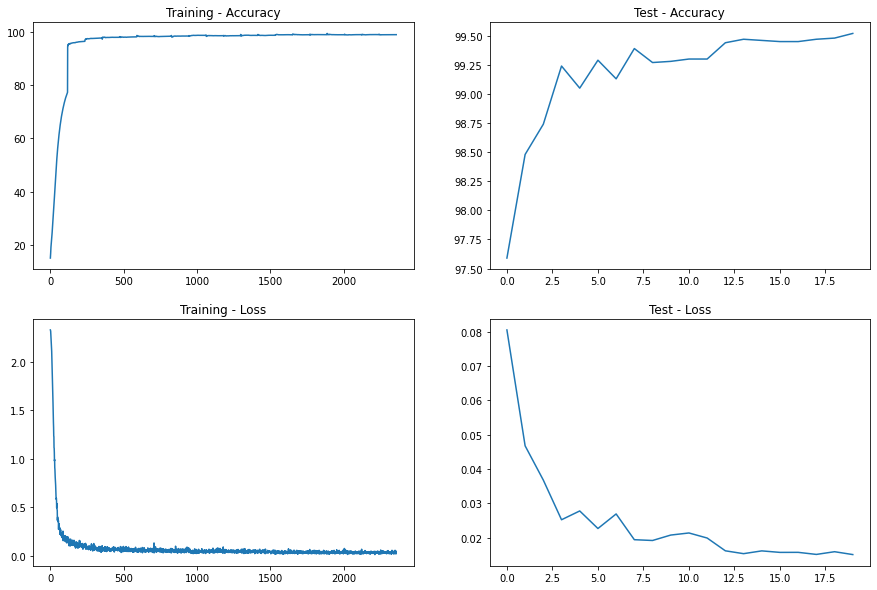

In [12]:
def plot_performance(train_acc, test_acc,train_losses,test_losses ):
  fig, axs = plt.subplots(2,2,figsize=(15,10))

  axs[0, 0].plot(train_acc)
  axs[0, 0].set_title("Training - Accuracy")
  axs[0, 1].plot(test_acc)
  axs[0, 1].set_title("Test - Accuracy")

  axs[1, 0].plot(train_losses)
  axs[1, 0].set_title("Training - Loss")
  axs[1, 1].plot(test_losses)
  axs[1, 1].set_title("Test - Loss")

plot_performance(train_acc, test_acc,train_losses,test_losses)
